In [296]:
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.pylab import rcParams
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import accuracy_score
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Downloads/Dolt DB - DC - Sales.csv')  

In [3]:
df = df.drop(columns = ['state','city','county','source_url', 'sale_type', 'num_units', 'year_built', 'book', 'page', 'property_type', 'buyer_name','seller_name','property_id'])

In [4]:
df.head()

,zip5,physical_address,sale_date,sale_price
0,20003.0,1 18TH ST SE # 102,2020-11-24 00:00:00,0
1,20003.0,1 18TH ST SE # 103,2003-01-28 00:00:00,191050
2,20003.0,1 18TH ST SE # 104,2015-03-24 00:00:00,390000
3,20003.0,1 18TH ST SE # 201,2003-01-31 00:00:00,198350
4,20003.0,1 18TH ST SE # 203,2013-06-06 00:00:00,352500


for i in range(df.shape[0]):
    date = str(df.loc[i, 'sale_date'])
    df.loc[i,'sale_date'] = date[0:10]

In [5]:
df.head()

,zip5,physical_address,sale_date,sale_price
0,20003.0,1 18TH ST SE # 102,2020-11-24 00:00:00,0
1,20003.0,1 18TH ST SE # 103,2003-01-28 00:00:00,191050
2,20003.0,1 18TH ST SE # 104,2015-03-24 00:00:00,390000
3,20003.0,1 18TH ST SE # 201,2003-01-31 00:00:00,198350
4,20003.0,1 18TH ST SE # 203,2013-06-06 00:00:00,352500


In [6]:
df['sale_date'] = pd.to_datetime(df['sale_date'], infer_datetime_format=True)

In [20]:
dat = str(df.loc[0,'sale_date'])[0:4]

In [256]:
df['sale_label'] = df.sale_price//100_000

In [257]:
date_list = []
date_2020 = []
for year in range(2016,2021):
    if year < 2020:
        for month in range(1,13):
            d = str(year) + '-' + str(month)
            date_list.append(d)
    else:
        for month in range(1,13):
            d = '2020' + '-' + str(month)
            date_2020.append(d)
        

In [328]:
zip_codes = df.zip5.unique()
zip_codes = list(zip_codes[~(np.isnan(zip_codes))])

good_zips = []

scores = []
for code in zip_red:
    
    try:
        new_df = pd.DataFrame(index = range(df.shape[0]), columns = date_list)
        new_df_2020 = pd.DataFrame(index = range(df.shape[0]), columns = date_2020)
        df_recent  = pd.DataFrame()
        df_2020 = pd.DataFrame()

        q3, q1 = np.percentile(df[df.zip5 == code]['sale_price'], [75 ,25]) # code here
        iqr = q3 - q1
        max_val = 1.5*iqr + q3

        df_code = df[(df.zip5 == code) & (df.sale_price < max_val)]  # code here
        df_recent  = pd.DataFrame()
        df_2020 = pd.DataFrame()
        for i, row in df_code.iterrows():
            y = df_code.loc[i,'sale_date'].year
            if y >= 2016 and y < 2020 and df_code.loc[i,'sale_price'] > 0:
                df_recent = df_recent.append(row)
            elif y == 2020 and df_code.loc[i,'sale_price'] > 0:
                df_2020 = df_2020.append(row)

        df_recent = df_recent.reset_index(drop=True)
        df_2020 = df_2020.reset_index(drop=True)


        for ind in range(df_recent.shape[0]):
            y = str(df_recent.loc[ind,'sale_date'].year)
            m = str(df_recent.loc[ind,'sale_date'].month)
            day = str(df_recent.loc[ind,'sale_date'].day)
            d = y + '-' + m + '-' + day
            new_df.loc[ind,d] = df_recent.loc[ind, 'sale_price']

        for ind in range(df_2020.shape[0]):
            m = str(df_recent.loc[ind,'sale_date'].month)
            day = str(df_recent.loc[ind,'sale_date'].day)
            d = '2020' + '-' + m + '-' + day
            new_df_2020.loc[ind,d] = df_2020.loc[ind, 'sale_price']


        time_series = new_df.mean()[48:]
        test_series = new_df_2020.mean()[12:]

        dftest = sm.tsa.stattools.adfuller(time_series, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
        ##########################################################################################################################


        inds = []
        test_inds = []
        for i in range(len(time_series)):
            inds.append(datetime.strptime(time_series.index[i], '%Y-%m-%d'))
        for i in range(len(test_series)):
             test_inds.append(datetime.strptime(test_series.index[i], '%Y-%m-%d'))

        time_series.index = inds
        time_series = time_series.sort_index()

        test_series.index = test_inds
        test_series = test_series.sort_index()

        dftest = sm.tsa.stattools.adfuller(time_series, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

        predictions = auto_reg.predict(start=len(time_series), end=len(time_series) + len(test_series)-1, dynamic=False)

        score = accuracy_score(test_series//100_000, predictions//100_000)
        scores.append(score)
        good_zips.append(code)
    except: 
        pass

In [302]:
np.sqrt(mean_squared_error(test_series, predictions))

238059.5088619221

<AxesSubplot:>

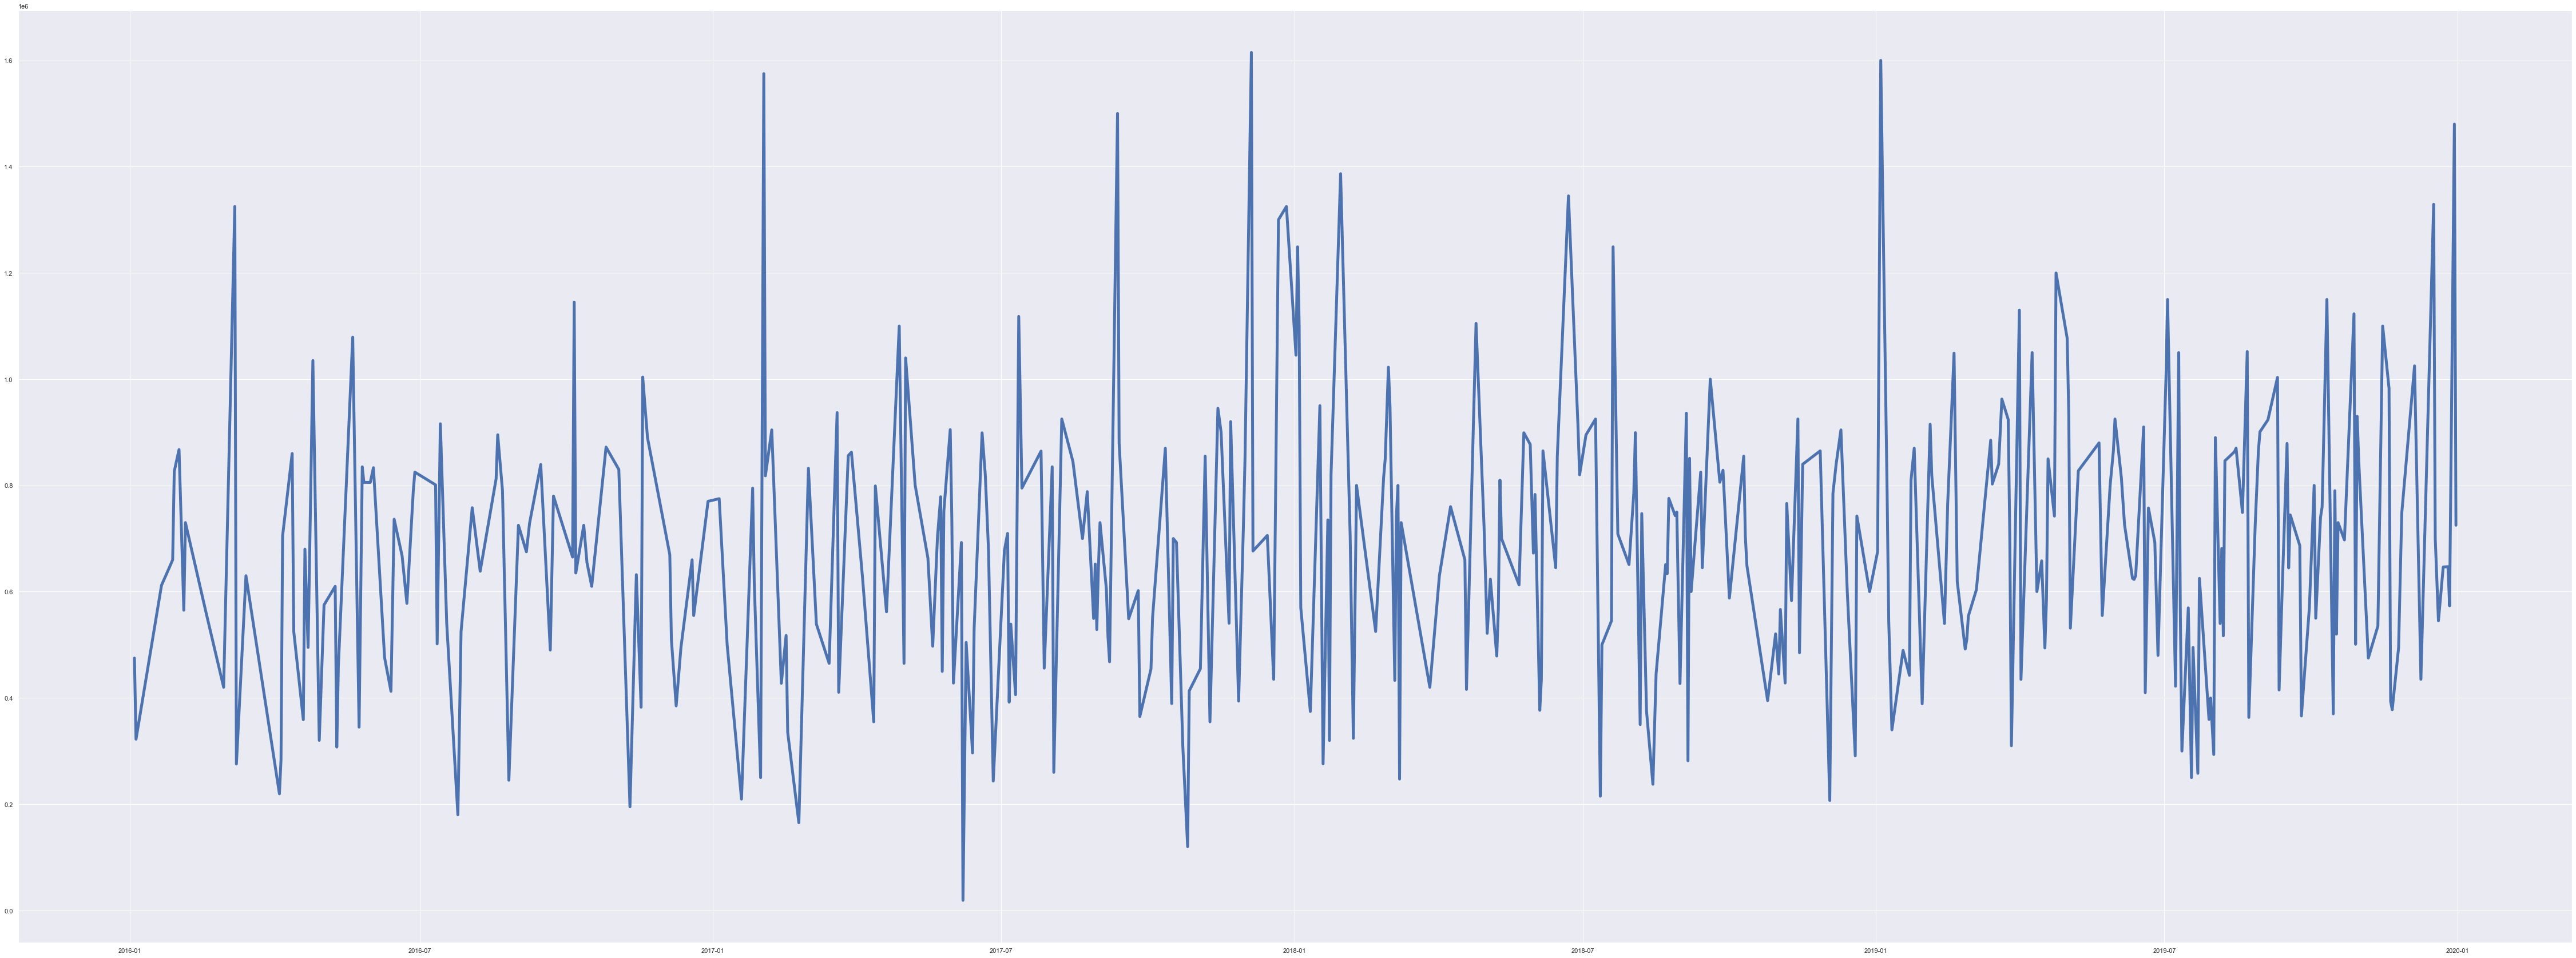

In [214]:
sns.set(rc = {'figure.figsize':(80,30)})
sns.lineplot(data=time_series, x= time_series.index, y= time_series, linewidth = 5)

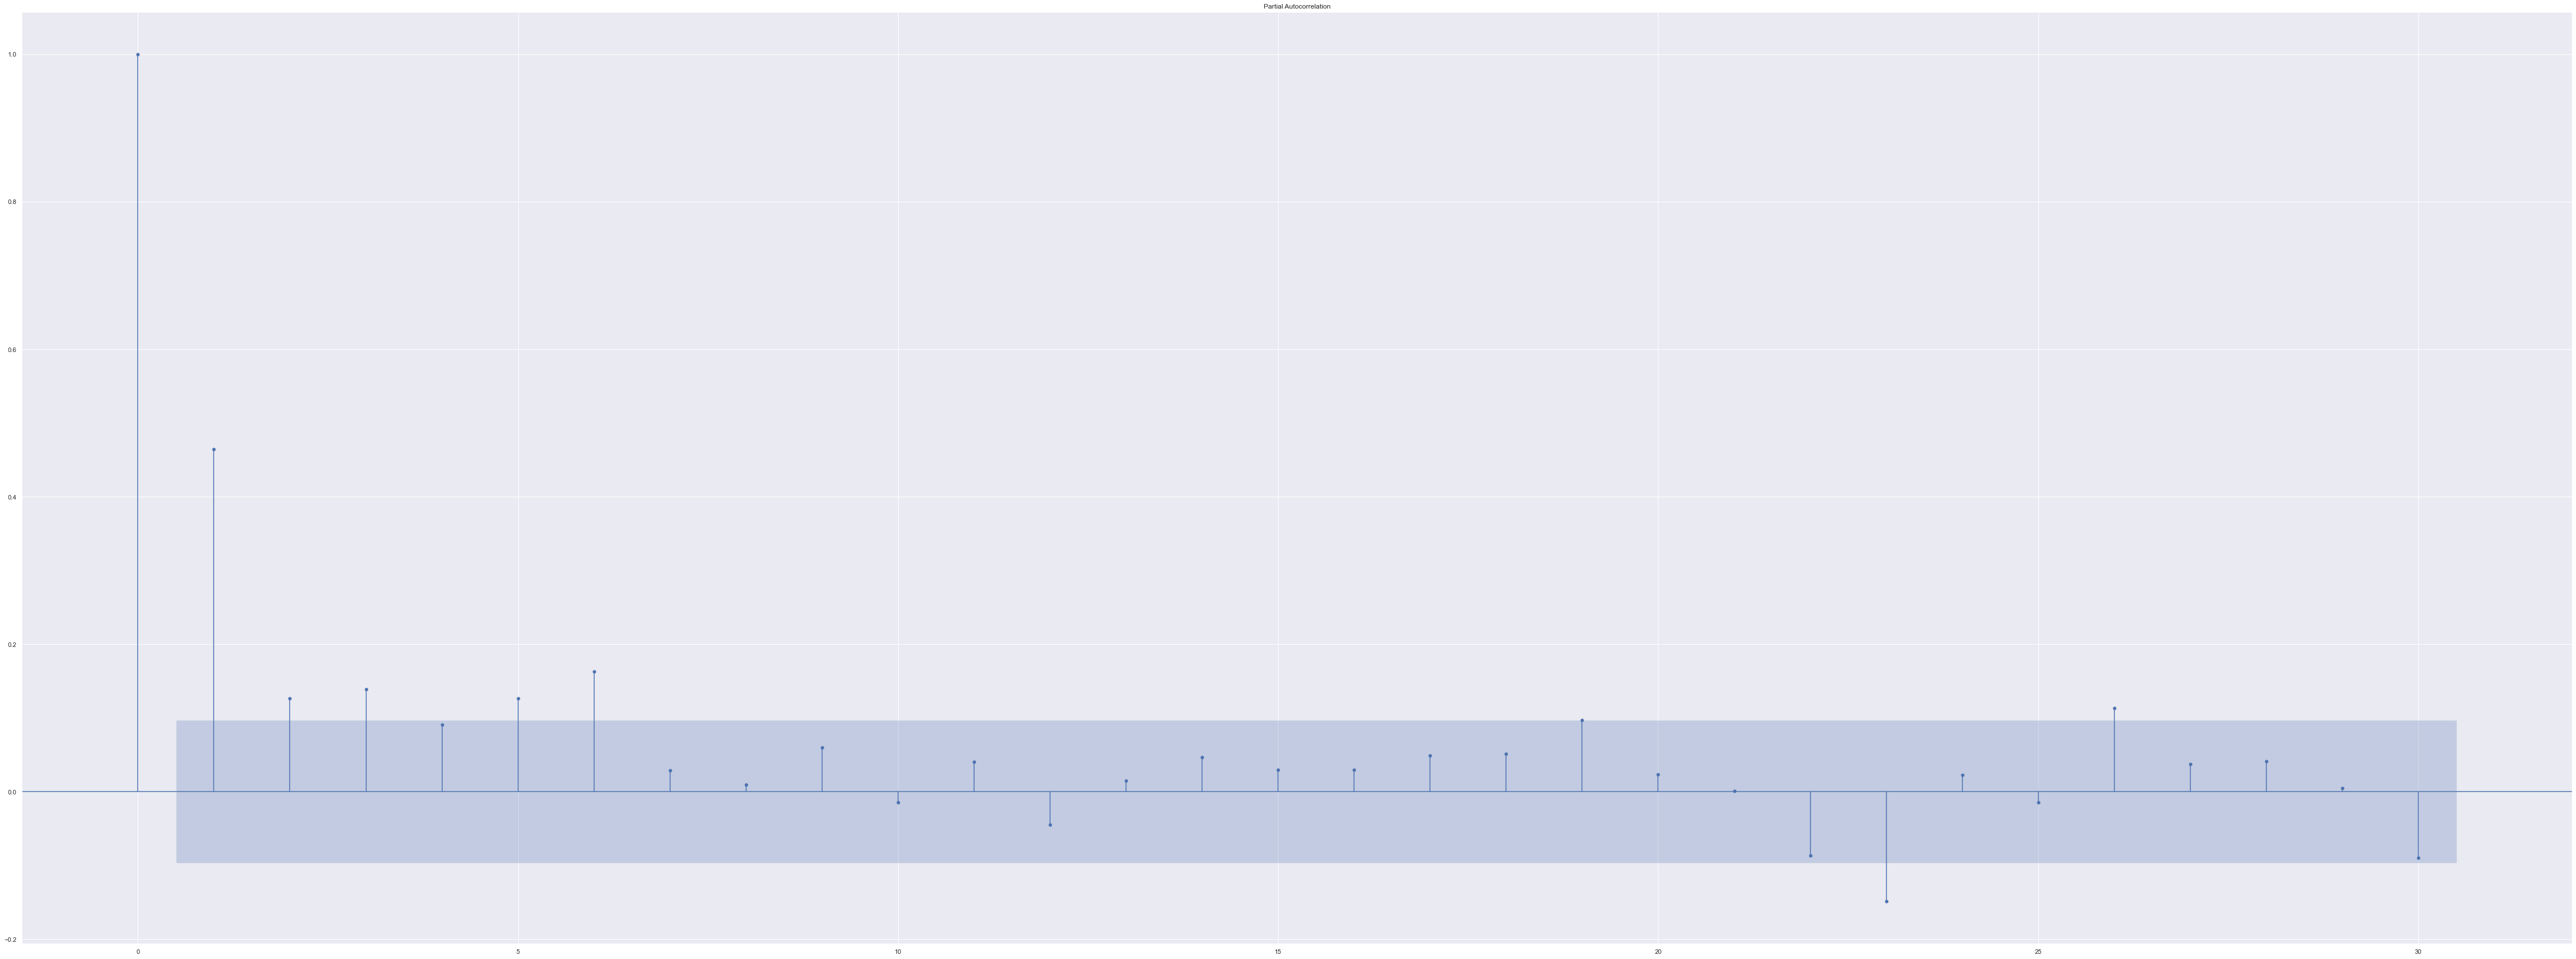

In [197]:
pacf=plot_pacf(time_series, lags=30)

In [ ]:
dftest = sm.tsa.stattools.adfuller(new_df.mean()[48:], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

auto_reg = AutoReg(time_series, lags=6).fit()

predictions = auto_reg.predict(start=len(time_series), end=len(time_series) + len(test_series)-1, dynamic=False)

test_series.index = test_series.index.sort_values()
predictions.index = test_series.index


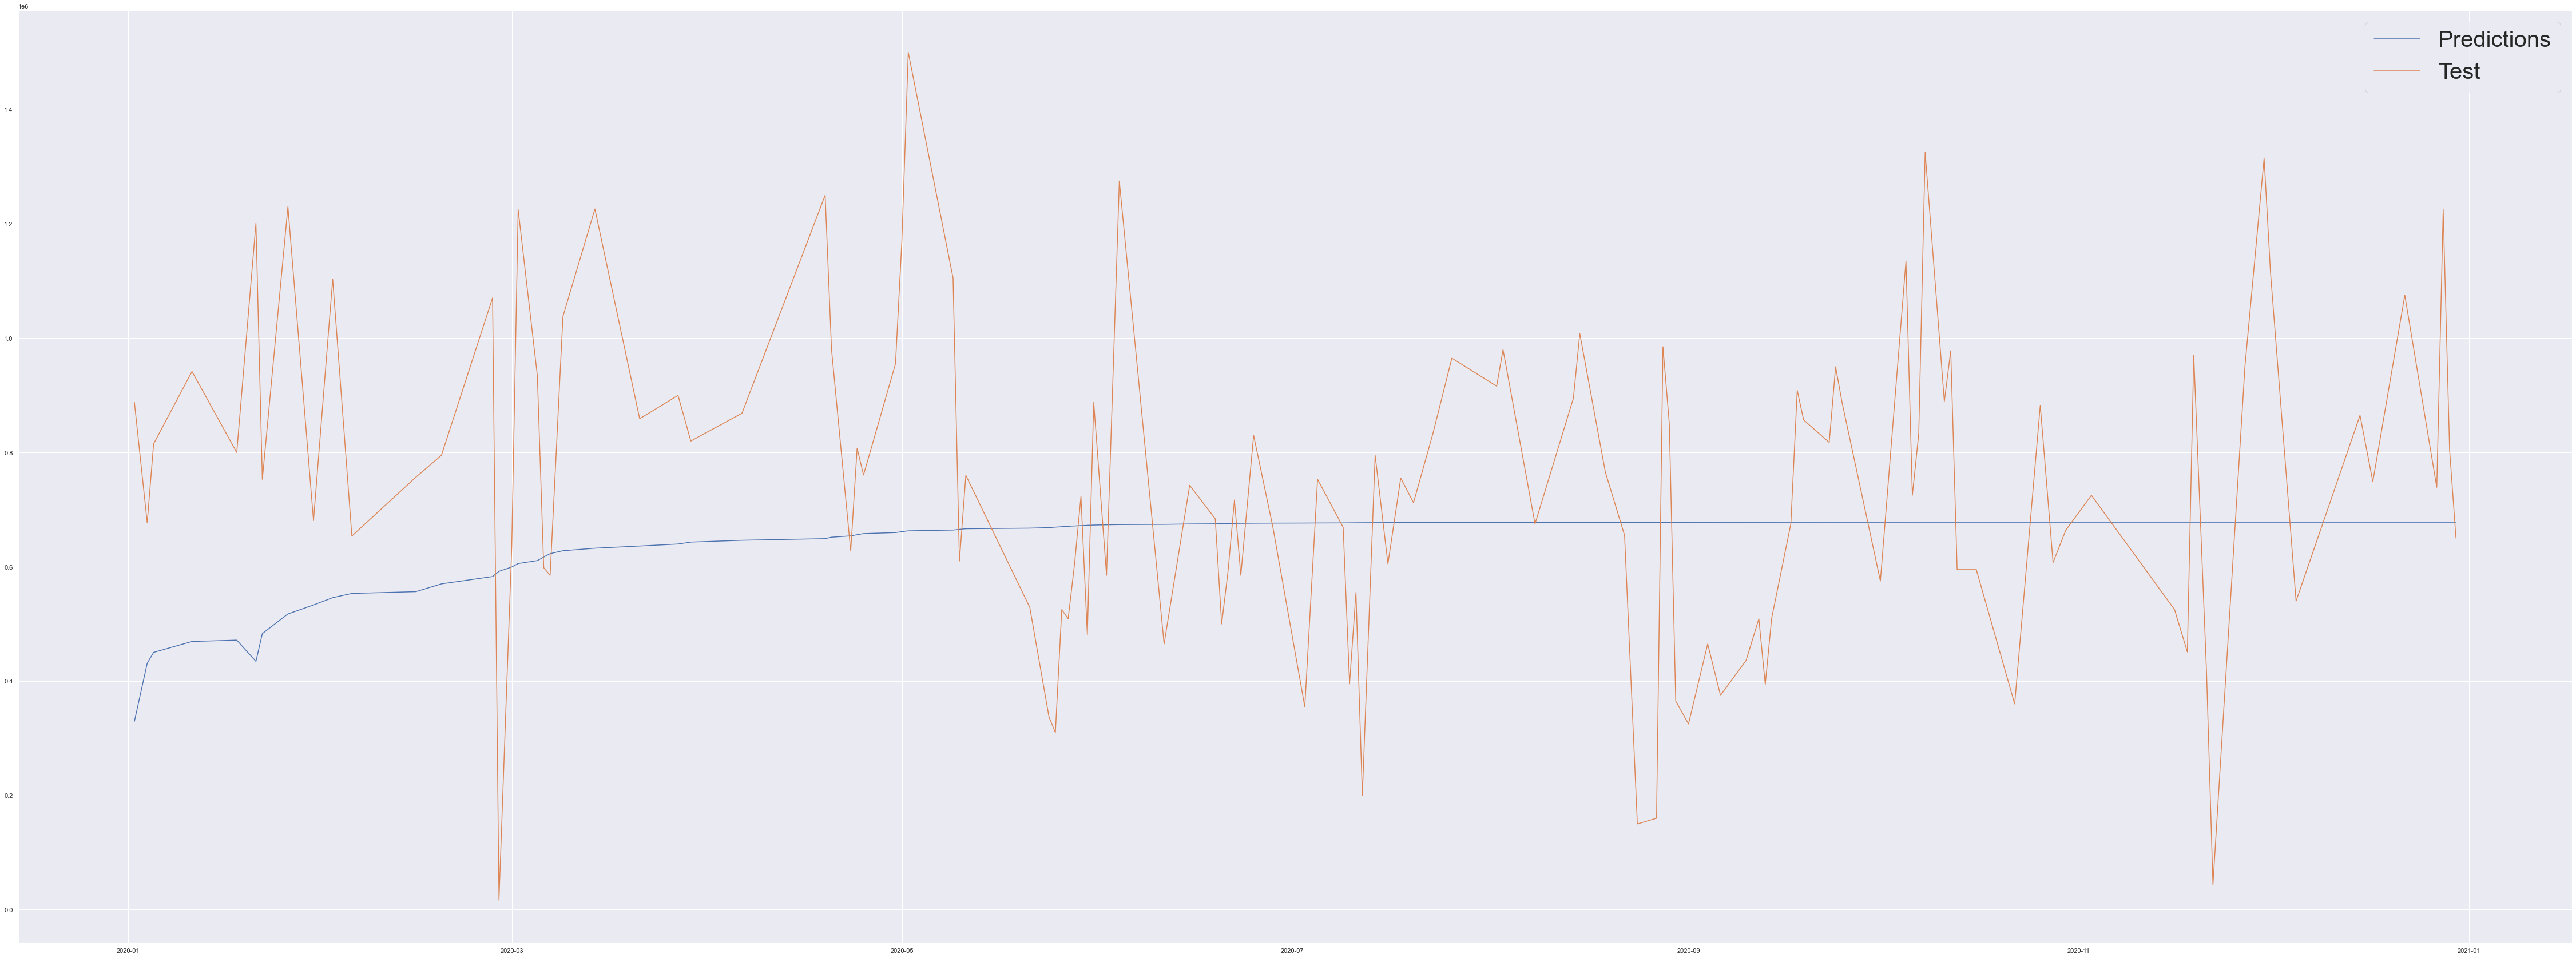

In [245]:
plt.plot(predictions, label='Predictions')
plt.plot(test_series, label='Test')
plt.legend(prop={'size': 40})